In [20]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import cmcrameri.cm as cm


In [147]:
import utils.load_grid as lg
import utils.feathers
from proteus.config import read_config
from proteus.utils.plot import get_colour
from proteus.atmos_clim.common import read_atmosphere_data
from proteus.interior.wrapper import read_interior_data

from proteus.utils.constants import R_earth, M_earth

In [3]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'
# %matplotlib widget

In [4]:
pgrid_dir = "data/shared/l98d_habrok2/"
cases = lg.get_cases(pgrid_dir, only_completed=True)
ncases = len(cases)

cnums = [int(s.split("_")[-1]) for s in cases]
stts = lg.get_statuses(pgrid_dir)
helps, hvars = lg.load_helpfiles(cases)

confs = []
for f in cases:
    confs.append( read_config(f+"/init_coupler.toml") )

age_start = float(helps[0]["age_star"].iloc[0])

print("Done")

Helpfiles: 100%|██████████| 554/554 [00:36<00:00, 15.27it/s]


Done


### Make plots

In [5]:
case = 224

In [6]:
idx = cnums.index(case)

print(lg.descend_get(confs[idx],"params.out.path"))
print(lg.descend_get(confs[idx],"outgas.fO2_shift_IW"))

scratch/l98d_habrok2/case_00224/
-3.0


In [7]:
print("Psurf = %.2f bar"%(helps[idx]["P_surf"].iloc[-1]))
print("rho = %.2f g/cc"%(helps[idx]["rho_obs"].iloc[-1]/1e3))

Psurf = 30097.97 bar
rho = 3.43 g/cc


In [29]:
# load netcdfs
outdir = cases[idx]
print(outdir)
t_arr  = lg.get_nc_years(cases[idx])
nc_arr = read_atmosphere_data(cases[idx], t_arr)
js_arr = read_interior_data(cases[idx], "spider", t_arr)

/home2/p321409/Projects/analysis/data/shared/l98d_habrok2/case_00224


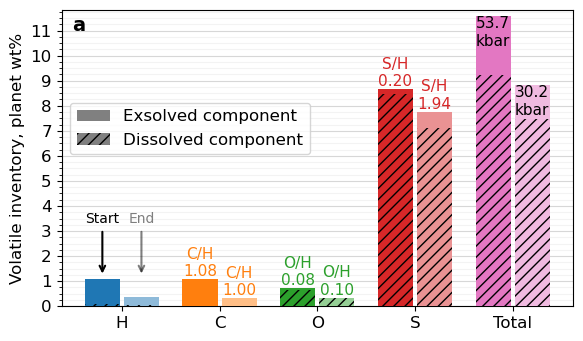

In [175]:
figscale = 1.1
fig, ax = plt.subplots(1,1, figsize=(6*figscale, 3.5*figscale))

elems = ['H', 'C', 'O', 'S']

dx = 2.5
dc = 1.0
bw = 0.9
ht = "///"
fs = 11

i0 = 5
i1 = -2

# totals
t_liq_0 = 0.0
t_atm_0 = 0.0
t_liq_1 = 0.0
t_atm_1 = 0.0

for i,e in enumerate(elems):

    col = "C"+str(i)
    al = 0.5

    # start of simulation
    yunit = helps[idx]["M_planet"].iloc[i0] / 100

    e_liq = helps[idx][e+"_kg_liquid"].iloc[i0] / yunit
    ax.bar(i*dx, e_liq,  color=col, hatch=ht, width=bw, zorder=5)
    t_liq_0 += e_liq

    e_atm = helps[idx][e+"_kg_atm"].iloc[i0] / yunit
    ax.bar(i*dx, e_atm, bottom=e_liq, color=col, width=bw, zorder=5)
    t_atm_0 += e_atm

    if e != 'H':
        XH = helps[idx][e+"_kg_atm"].iloc[i0] / helps[idx]["H_kg_atm"].iloc[i0]
        ax.text(i*dx, e_atm+e_liq, "%s/H\n%.2f"%(e,XH),
                    ha='center', va='bottom', fontsize=fs, color=col, zorder=8)


    # end of simulation
    yunit = helps[idx]["M_planet"].iloc[i1] / 100

    e_liq = helps[idx][e+"_kg_liquid"].iloc[i1] / yunit
    ax.bar(i*dx+dc, e_liq,  color='w', width=bw, zorder=4)
    ax.bar(i*dx+dc, e_liq,  color=col, hatch=ht, alpha=al, width=bw, zorder=5)
    t_liq_1 += e_liq

    e_atm = helps[idx][e+"_kg_atm"].iloc[i1] / yunit
    ax.bar(i*dx+dc, e_atm, bottom=e_liq, color='w', width=bw, zorder=4)
    ax.bar(i*dx+dc, e_atm, bottom=e_liq, color=col, alpha=al, width=bw, zorder=5)
    t_atm_1 += e_atm

    if e != 'H':
        XH = helps[idx][e+"_kg_atm"].iloc[i1] / helps[idx]["H_kg_atm"].iloc[i1]
        ax.text(i*dx+dc, e_atm+e_liq, "%s/H\n%.2f"%(e,XH),
                    ha='center', va='bottom', fontsize=fs, color=col, zorder=8)

# total
col = "tab:pink"
#   start
x = len(elems)*dx
ax.bar(x, t_liq_0,                    color=col, zorder=5, width=bw, hatch=ht)
ax.bar(x, t_atm_0, bottom=t_liq_0,    color=col, zorder=5, width=bw)
ax.text(x, t_atm_0 + t_liq_0, "%.1f\nkbar"%(helps[idx]["P_surf"].iloc[i0]/1e3),
                    ha='center', va='top', fontsize=fs, color='k', zorder=8)
#   end
x = len(elems)*dx+dc
ax.bar(x, t_liq_1,                 color='w', zorder=4, width=bw)
ax.bar(x, t_liq_1,                 color=col, zorder=5, width=bw, alpha=al, hatch=ht)
ax.bar(x, t_atm_1, bottom=t_liq_1, color='w', zorder=4, width=bw)
ax.bar(x, t_atm_1, bottom=t_liq_1, color=col, zorder=5, width=bw, alpha=al)
ax.text(x, t_atm_1 + t_liq_1, "%.1f\nkbar"%(helps[idx]["P_surf"].iloc[i1]/1e3),
                    ha='center', va='top', fontsize=fs, color='k', zorder=8)

# legend
col = 'grey'
ax.bar([0],[0], color=col, label="Exsolved component")
ax.bar([0],[0], color=col, hatch=ht, label="Dissolved component")


# annotate
for d in zip(("Start","End"),(0,dc),(1,al)):

    yb = helps[idx]["H_kg_total"].iloc[i0] / helps[idx]["M_planet"].iloc[i0] * 100 * 1.1

    ax.annotate(d[0], xy=(d[1], yb), xytext=(d[1], yb+2),
            arrowprops=dict(arrowstyle="->", lw=1.5,alpha=d[2]),
            fontsize=10, ha='center', va='bottom', alpha=d[2])

# decorate
ax.set_xticks(np.arange(0,(len(elems)+1)*dx, dx)+dc/2)
ax.set_xticklabels(elems + ["Total"])
ax.set_ylabel("Volatile inventory, planet wt%")

ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.grid(axis='y', zorder=-2, alpha=0.5, which='major')

ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax.grid(axis='y', zorder=-2, alpha=0.15, which='minor')

ax.set_ylim(bottom=0,top=t_atm_0+t_liq_0+0.25)

ax.text(0.02, 0.98, "a", ha='left', va='top', fontsize=14, transform=ax.transAxes, fontweight='bold')

ax.legend(loc='center left', bbox_to_anchor=(0.0, 0.6))

plt.show()
fig.savefig("output/fig_inventory.pdf", bbox_inches='tight', dpi=300)

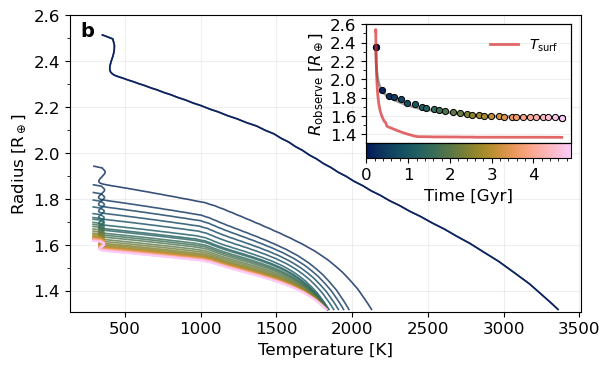

In [181]:
figscale = 1.1
fig, ax = plt.subplots(1,1, figsize=(6*figscale, 3.5*figscale))


axi_h = 0.4
axi_w = 0.4
axi_y = 0.03
axi_x = 0.02
axi_c = 0.05
axi = ax.inset_axes((1-axi_w - axi_x, 1-axi_h - axi_y,         axi_w, axi_h), )
axc = ax.inset_axes((1-axi_w - axi_x, 1-axi_h - axi_y - axi_c, axi_w, axi_c), )

t_gyr = t_arr / 1e9
norm = mpl.colors.Normalize(vmin=0, vmax=np.amax(t_gyr))
sm = plt.cm.ScalarMappable(cmap=cm.batlow, norm=norm)
sm.set_array([])


R_int = helps[idx]["R_int"].iloc[-1] / R_earth

# time array
time_plt = np.linspace(0, np.amax(t_gyr), 30)
idx_plt  = [0] + [np.argmin(np.abs(t_gyr - time)) for time in time_plt] + [len(t_gyr)-1]
idx_plt  = sorted(idx_plt)

# plot samples
for i in idx_plt:

    atm_t = nc_arr[i]["t"][::-1]
    atm_r = nc_arr[i]["r"][::-1] / R_earth

    time = t_gyr[i]

    color = sm.to_rgba(time)
    al = 0.8
    lw = 1.2

    ax.plot(atm_t, atm_r, color=color, lw=lw, alpha=al, zorder=5+i)
    axi.scatter(time, helps[idx]["R_obs"].iloc[i]/R_earth, color=color, s=20, lw=0.7, edgecolor='k', zorder=5+i)

# plot R_obs over time, line
axi.plot(helps[idx]["Time"]/1e9, helps[idx]["R_obs"]/R_earth, color='grey', lw=2, alpha=0.8, zorder=4)

axr = axi.twinx()
axr.plot(helps[idx]["Time"]/1e9, helps[idx]["T_surf"], color='tab:red', lw=2, alpha=0.7, zorder=1, label=r"$T_\text{surf}$")
axr.legend(loc='upper right', frameon=False, fontsize=10)
axr.set_yticks([])

# main axis labels
ax.set_xlabel("Temperature [K]")
ax.set_ylabel(r"Radius [R$_\oplus$]")

# main and inset axes
for axx in (ax, axi):
    axx.grid(alpha=0.2, zorder=-2)
    axx.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
    axx.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
    axx.set_ylim(bottom=R_int-0.01, top=2.6)

# inset axis labels
axi.set_ylabel(r"$R_\text{observe}$ $[R_\oplus]$")

# colorbar
axi.set_xticks([])
cb = fig.colorbar(sm, cax=axc, orientation='horizontal', label="Time [Gyr]")
cb.ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
cb.ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))

# panel label
ax.text(0.02, 0.98, "b", ha='left', va='top', fontsize=14, transform=ax.transAxes, fontweight='bold')

plt.show()
fig.savefig("output/fig_contract.pdf", bbox_inches='tight', dpi=300)